In [2]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.IDEC import *
from models.simclr.simclr import *
from models.simclr.transforms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.7.1
torchvision: 0.8.2
numpy: 1.19.4
scikit-learn: 0.24.0
Using device:  cpu


In [5]:
# specify learning params
batch_size = 264
learning_rate = 1e-3
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the Random SimCLR model

In [6]:
def encode_batchwise(dataloader, model, device):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        vec, proj = model(batch_data)
        embeddings.append(vec.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [13]:
test_data = load_util.load_custom_cifar('./data', download=False, for_model='SimCLR', train=False, data_percent=1.0)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=True)

In [20]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}
lc = np.array(lable_classes)

In [16]:
nmis = {}
pcas = {}

In [17]:
names = ['pretrained_SimCLR_r18_200', 'IDEC_SimCLR_r18_e100', 'IDEC_SimCLR_r18_e200', 'IDEC_SimCLR_r18_e300']
for name in names:
    if 'pretrained' in name:
        model = SimCLR(resnet_model='resnet18')
    else:
        model = IDEC()

    state_dict = torch.load(f'trained_models/{name}.pth', map_location='cpu')
    model.load_state_dict(state_dict)
    
    if 'pretrained' in name:
        decoder = model
    else:
        decoder = model.model
    
    print(f'{name}')
    print('Starting encoding...')
    embedded_data, labels = encode_batchwise(testloader, decoder, device)
    lable_classes=[colors_classes[l] for l in labels]

    print('Starting KMeans...')
    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)
    nmis[name] = nmi

    print('Starting PCA...')
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)
    pcas[name] = reduced_data

pretrained_SimCLR_r18_200
Starting encoding...
Starting KMeans...
Starting PCA...


/Users/godlinn/Documents/Studium/WS2020/Bachelor/DeepClusteringLoss/models/dec/DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_SimCLR_r18_e100
Starting encoding...
Starting KMeans...
Starting PCA...


/Users/godlinn/Documents/Studium/WS2020/Bachelor/DeepClusteringLoss/models/dec/DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_SimCLR_r18_e200
Starting encoding...
Starting KMeans...
Starting PCA...


/Users/godlinn/Documents/Studium/WS2020/Bachelor/DeepClusteringLoss/models/dec/DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_SimCLR_r18_e300
Starting encoding...
Starting KMeans...
Starting PCA...


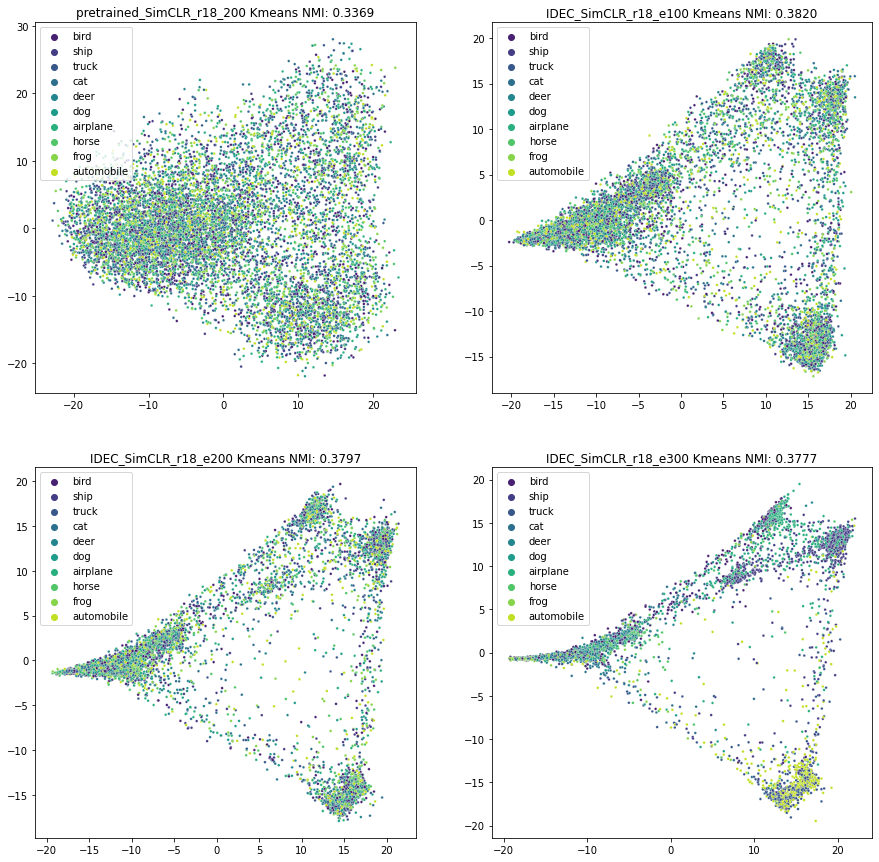

In [18]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()

for i, ver in enumerate(nmis.keys()):
    axes[i].set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=7, palette='viridis')  

pretrained_SimCLR_r18_200 class representation


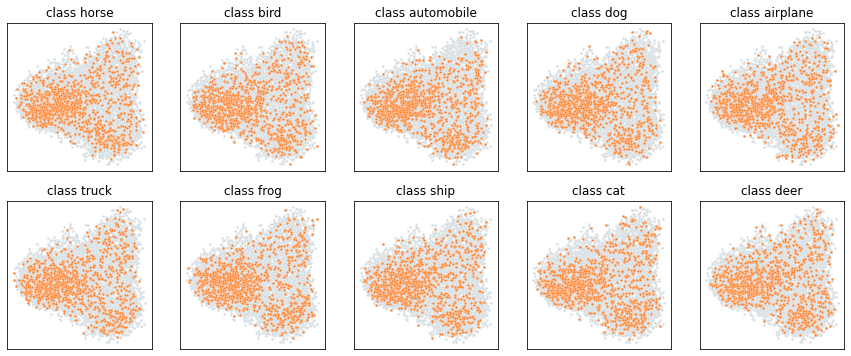

IDEC_SimCLR_r18_e100 class representation


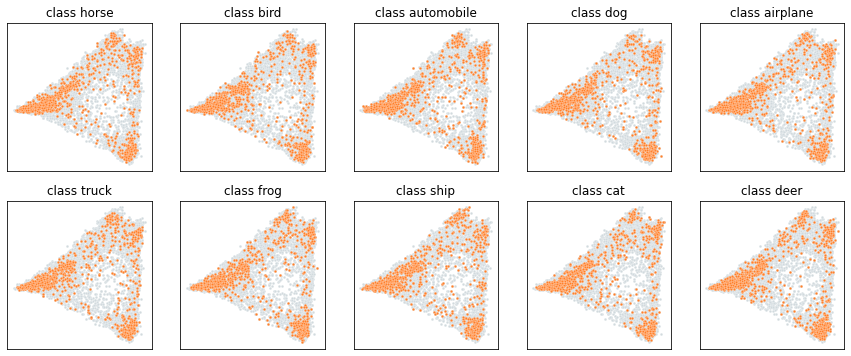

IDEC_SimCLR_r18_e200 class representation


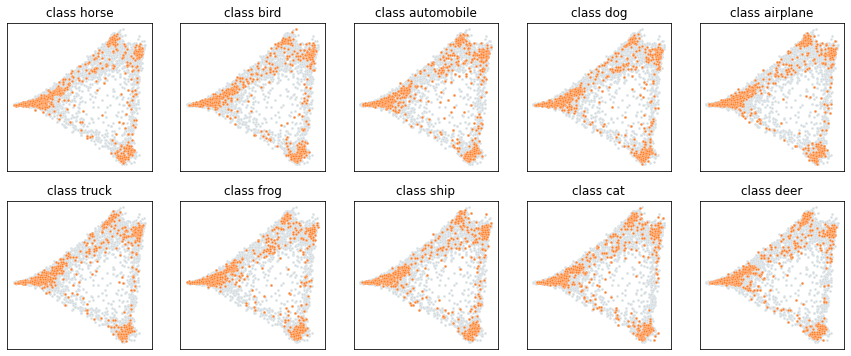

IDEC_SimCLR_r18_e300 class representation


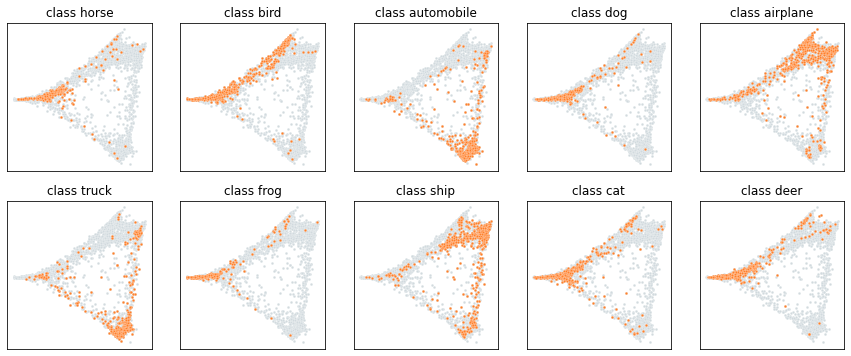

In [21]:
for ver in nmis.keys():
    print(f'{ver} class representation')
    fig, axes = plt.subplots(2,5, figsize=(15,6))
    axes = axes.flatten()

    for i, c in enumerate(set(lable_classes)):
        ids = np.where(lc==c)[0]
        axes[i].set(title=f'class {c}')
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
        sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')
        
    plt.show()

The representation definetely gets better after training with IDEC. "Noise" from the middle slowly moves toward cluster centers. Classifications (and the errors in the classification) make sense: auto and truck are in the same cluster, birds are classified somewhere between airplane and "animals". Animal classifications differ slightly but all of them kinda go to the left "corner".
I think the problem is that pretrained data representation is not optimal, it seems the net did not really learn more detailed differences. My guess is that if I train with ResNet50 as a base and on the whole dataset, the pretrained representation should get better result (because SimCLR relies on comparison between images and bigger batches)